# DataManager Tutorial − Initiation to the DataManager class

@Author : [MEDomics consortium](https://github.com/medomics/)

@Email : medomics.info@gmail.com


**STATEMENT**:
This file is part of <https://github.com/MEDomics/MEDomicsLab/>,
a package providing PYTHON programming tools for radiomics analysis.
--> Copyright (C) MEDomicsLab consortium.

## Introduction


This notebook is a tutorial for the *DataManager* class to give a detailed introduction & explanation on how to use this Python class. The *DataManager* class is the main object used in the *MEDimage* package when it comes to processing raw data in NIfTI and DICOM formats. This class can:
 - Create ``MEDscan`` class objects from the raw data and makes the manipulation of these objects easy.
 - Help find the proper dimension and re-segmentation ranges options for radiomics analysis by running some pre-computation checks.

In this tutorial, we will go through all this step by step and help you learn everything you need about the *DataManager* class.

The ``DataManager`` class is one of the first operation done in the radiomics analysis workflow, because it helps create the ``MEDscan`` class objects which is the main asset used in the *MEDimage* package.

<img src="images/MEDimageFlowchart.png"/>

Let's take a look inside the ``DataManager`` box:

<img src="images/DataManager-workflow.png"/>

Make sure your folder structure looks like the figure below, it is the same as the repository structure but you need to download the imaging data and place in *DICOM-STS*:

<img src="images/DataManagerFolderStructure.png"/>

Imports

In [1]:
import os
import sys

MODULE_DIR = os.path.dirname(os.path.abspath('../MEDimage/'))
sys.path.append(os.path.dirname(MODULE_DIR))

import MEDimage

PyCUDA is not installed. Please install it to use the textural filters.


## Dataset

The data used here consists of 204 different scans, with different scan types (MR, PET, CT) and with different contours (regions of interest) of the STS (soft tissue sarcoma) cancer. Every datasets should have a csv along with it. In our case, our dataset is linked to 4 csv files, every csv file contains information about the ROI we are dealing with for each scan:
 - **GTV mass**: Contains scans with GTV mass contours.
 - **GTV edema**: Contains scans with GTV edema contours.
 - **GTV ring**: Contains scans with GTV mass contours included but GTV edema contours excluded.
 - **GTV**: A more general csv containing all scans with combined ROI contours.
You can find the csv files for this dataset in *csv* folder the repository. We will start by loading all the files here and taking a look into it before we go deeper in the ``DataManager`` class.

In [2]:
import pandas

from pathlib import Path

path_csv_mass = Path(os.getcwd()) / "CSV" / "roiNames_GTVmass.csv"
path_csv_edema = Path(os.getcwd()) / "CSV" / "roiNames_GTVedema.csv"
path_csv_ring = Path(os.getcwd()) / "CSV" / "roiNames_GTVring.csv"
path_csv = Path(os.getcwd()) / "CSV" / "roiNames_GTV.csv"

pandas.read_csv(path_csv_mass)

,PatientID,ImagingScanName,ImagingModality,ROIname
0,STS-McGill-001,T1,MRscan,{GTV_Mass}
1,STS-McGill-001,CT,CTscan,{GTV_Mass}
2,STS-McGill-001,PET,PTscan,{GTV_Mass}
3,STS-McGill-001,T2FS,MRscan,{GTV_Mass}
4,STS-McGill-002,T1,MRscan,{GTV_Mass}
...,...,...,...,...
199,STS-McGill-050,T2FS,MRscan,{GTV_Mass}
200,STS-McGill-051,T1,MRscan,{GTV_Mass}
201,STS-McGill-051,CT,CTscan,{GTV_Mass}
202,STS-McGill-051,PET,PTscan,{GTV_Mass}


In [3]:
pandas.read_csv(path_csv_edema)

,PatientID,ImagingScanName,ImagingModality,ROIname
0,STS-McGill-001,T1,MRscan,{GTV_Edema}
1,STS-McGill-001,CT,CTscan,{GTV_Edema}
2,STS-McGill-001,PET,PTscan,{GTV_Edema}
3,STS-McGill-001,T2FS,MRscan,{GTV_Edema}
4,STS-McGill-002,T1,MRscan,{GTV_Edema}
...,...,...,...,...
123,STS-McGill-048,T2FS,MRscan,{GTV_Edema}
124,STS-McGill-050,T1,MRscan,{GTV_Edema}
125,STS-McGill-050,CT,CTscan,{GTV_Edema}
126,STS-McGill-050,PET,PTscan,{GTV_Edema}


In [4]:
pandas.read_csv(path_csv_ring)

,PatientID,ImagingScanName,ImagingModality,ROIname
0,STS-McGill-001,T1,MRscan,{GTV_Edema}-{GTV_Mass}
1,STS-McGill-001,CT,CTscan,{GTV_Edema}-{GTV_Mass}
2,STS-McGill-001,PET,PTscan,{GTV_Edema}-{GTV_Mass}
3,STS-McGill-001,T2FS,MRscan,{GTV_Edema}-{GTV_Mass}
4,STS-McGill-002,T1,MRscan,{GTV_Edema}-{GTV_Mass}
...,...,...,...,...
123,STS-McGill-048,T2FS,MRscan,{GTV_Edema}-{GTV_Mass}
124,STS-McGill-050,T1,MRscan,{GTV_Edema}-{GTV_Mass}
125,STS-McGill-050,CT,CTscan,{GTV_Edema}-{GTV_Mass}
126,STS-McGill-050,PET,PTscan,{GTV_Edema}-{GTV_Mass}


So in general, the csv is a summary of the scans in the dataset that is organized this way:
- **PatientID**: ID of the patient or scan
- **ImagingScanName**: Imaging scan name or known as series_description in DICOM headers.
- **ImagingModality**: Imaging modality (MRcsan, PTscan or CTscan).
- **ROInames**: Names of the ROIs that will be processed and extracted in the analysis.

## DataManager initialization

As mentioned before we are gonna use ``DataManager`` class to create ``MEDscan`` objects from raw data, we will use DICOM files only, but the process is the same for NIfTI format. We will only need path to the data folder (folder that hold all the data). The class diagram below shows the different attributes and methods. What's worth noting is:
- ``process_all()`` method which process all type of data (NIfTI or DICOM).
- ``process_all_dicoms`` method which process DICOM data only using the path to DICOM data (path given in initialization).
- ``process_all_niftis`` method which process NIfTI data only using the path to NIfTI data (path given in initialization).
- ``save`` attribute: if True will save the created ``MEDscan`` objects locally.
- ``instances`` attribute: Holds all the created ``MEDscan`` objects (can hold 10 objects maximum)

<img src="images/DataManagerClassDiagram.png"/>

We will go through all the functionalities of the ``DataManager`` class. For more details about the class please refer to the [DataManager documentation](https://medimage.readthedocs.io/en/documentation/wrangling.html#module-MEDimage.wrangling.DataManager)

### Initialization

The minimum information we need for initialization is a path to raw data folder, then we can call the ``DataManager`` from the ``wrangling`` sub-package. But we will add some other information:
 - ``path_save``: path to where the results are gonna be saved.
 - ``save``: ``True`` to save the created ``MEDscan`` objects. (If you have more than 10 scans in your dataset you must set it to ``True``)
 - ``n_batch``:  Numerical value specifying the number of batch to use in the parallel computations (use 0 for serial computation).
 - ``keep_instances``: ``True`` to keep the ``MEDscan`` objects in the ``DataManager`` instance specifically in the attribute ``instances``. This is only possible for small dataset with 10 scans or less.

In [5]:
path_dicoms_data = Path(os.getcwd()) / "data" / "DICOM-STS"
path_save = Path(os.getcwd()) / "data" / "npy"
path_save.mkdir() if not path_save.exists() else path_save
dm = MEDimage.wrangling.DataManager(path_to_dicoms=path_dicoms_data,
                                    path_save=path_save,
                                    path_csv=path_csv,
                                    n_batch=2)

We have now initialized the ``DataManager`` and we can call ``process_all_dicoms`` for DICOM data, ``process_all_niftis`` for NIfTI data or ``process_all`` for both to process our data. This method returns a list of instances for datasets with 10 scans or less (for memory considerations). In our case we have 204 scans so the scans will to be locally saved.

In [6]:
dm.process_all_dicoms()

2024-04-14 14:54:35,423	INFO worker.py:1743 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


--> Reading all DICOM objects to create MEDscan classes

--> Scanning all folders in initial directory...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3358/3358 [00:03<00:00, 850.48it/s]


DONE
--> Associating all RT objects to imaging volumes


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 334207.49it/s]
:job_id:01000000
:task_name:process_files_wrapper


DONE
--> Processing DICOMs and creating MEDscan objects
:job_id:01000000
:task_name:process_files_wrapper
:task_name:process_files_wrapper


:task_name:process_files_wrapper
  0%|                                                                                                                | 0/20 [00:00<?, ?it/s]:task_name:process_files_wrapper


:task_name:process_files_wrapper


  5%|█████▏                                                                                                  | 1/20 [00:00<00:10,  1.86it/s]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 10%|██████████▍                                                                                             | 2/20 [00:02<00:21,  1.21s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 15%|███████████████▌                                                                                        | 3/20 [00:03<00:21,  1.29s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 20%|████████████████████▊                                                                                   | 4/20 [00:07<00:35,  2.22s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 25%|██████████████████████████                                                                              | 5/20 [00:08<00:29,  1.95s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 30%|███████████████████████████████▏                                                                        | 6/20 [00:10<00:27,  1.96s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 35%|████████████████████████████████████▍                                                                   | 7/20 [00:11<00:18,  1.44s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 40%|█████████████████████████████████████████▌                                                              | 8/20 [00:13<00:22,  1.87s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 45%|██████████████████████████████████████████████▊                                                         | 9/20 [00:14<00:15,  1.41s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 50%|███████████████████████████████████████████████████▌                                                   | 10/20 [00:15<00:14,  1.46s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 55%|████████████████████████████████████████████████████████▋                                              | 11/20 [00:17<00:14,  1.57s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 60%|█████████████████████████████████████████████████████████████▊                                         | 12/20 [00:21<00:18,  2.34s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 65%|██████████████████████████████████████████████████████████████████▉                                    | 13/20 [00:23<00:15,  2.22s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 70%|████████████████████████████████████████████████████████████████████████                               | 14/20 [00:25<00:13,  2.19s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 15/20 [00:26<00:08,  1.73s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 16/20 [00:29<00:08,  2.11s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


 85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 17/20 [00:30<00:05,  1.74s/it]:task_name:process_files_wrapper


:task_name:process_files_wrapper


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.61s/it]

DONE


After this is done, we recommend calling the method ``summarize`` which is a class method that gives a summary of the processed scans depending on what CSV you are using for your data

In [7]:
dm.summarize()

| study   | institution   | scan_type   | roi_type   |   count |
|:--------|:--------------|:------------|:-----------|--------:|
| STS     |               |             |            |      20 |
| STS     | McGill        |             |            |      20 |
| STS     | McGill        | T1          |            |       5 |
| STS     | McGill        | CT          |            |       5 |
| STS     | McGill        | T2FS        |            |       5 |
| STS     | McGill        | PET         |            |       5 |


You can also change the dataset csv file and update your ``DataManager`` by calling the method ``update_from_csv`` that takes a path to your new csv as argument and automatically calls the method ``summarize`` at the end.

GTV Mass

In [8]:
dm.update_from_csv(path_csv_mass)

| study   | institution   | scan_type   | roi_type   |   count |
|:--------|:--------------|:------------|:-----------|--------:|
| STS     |               |             |            |      20 |
| STS     | McGill        |             |            |      20 |
| STS     | McGill        | T1          |            |       5 |
| STS     | McGill        | T1          | GTVmass    |       5 |
| STS     | McGill        | CT          |            |       5 |
| STS     | McGill        | CT          | GTVmass    |       5 |
| STS     | McGill        | T2FS        |            |       5 |
| STS     | McGill        | T2FS        | GTVmass    |       5 |
| STS     | McGill        | PET         |            |       5 |
| STS     | McGill        | PET         | GTVmass    |       5 |


GTV Edema

In [9]:
dm.update_from_csv(path_csv_edema)

| study   | institution   | scan_type   | roi_type   |   count |
|:--------|:--------------|:------------|:-----------|--------:|
| STS     |               |             |            |      20 |
| STS     | McGill        |             |            |      20 |
| STS     | McGill        | T1          |            |       5 |
| STS     | McGill        | T1          | GTVedema   |       4 |
| STS     | McGill        | CT          |            |       5 |
| STS     | McGill        | CT          | GTVedema   |       4 |
| STS     | McGill        | T2FS        |            |       5 |
| STS     | McGill        | T2FS        | GTVedema   |       4 |
| STS     | McGill        | PET         |            |       5 |
| STS     | McGill        | PET         | GTVedema   |       4 |


GTV Ring

In [10]:
dm.update_from_csv(path_csv_ring)

| study   | institution   | scan_type   | roi_type   |   count |
|:--------|:--------------|:------------|:-----------|--------:|
| STS     |               |             |            |      20 |
| STS     | McGill        |             |            |      20 |
| STS     | McGill        | T1          |            |       5 |
| STS     | McGill        | T1          | GTVring    |       4 |
| STS     | McGill        | CT          |            |       5 |
| STS     | McGill        | CT          | GTVring    |       4 |
| STS     | McGill        | T2FS        |            |       5 |
| STS     | McGill        | T2FS        | GTVring    |       4 |
| STS     | McGill        | PET         |            |       5 |
| STS     | McGill        | PET         | GTVring    |       4 |


We now have all scans converted to ``MEDscan`` objects saved locally in ``path_save``

## DataManager radiomics pre-checks

We have seen the first part of the use of the ``DataManager`` class that creates ``MEDscan`` objects from raw data. We will now use to run a pre-analysis of a certain group of scans. These pre-checks help find the proper dimension and re-segmentation ranges options for radiomics analysis by running some pre-computation checks. As seen in the class diagram above, it has many methods responsible for the pre-checks analysis:
- ``pre_radiomics_checks()`` runs radiomics checks to find proper dimension and re-segmentation ranges options.
- More methods for imaging summary will be added soon.
The use of the ``pre_radiomics_checks()`` needs a little attention because it requires more arguments that the methods we have tested before. First, we have to add a json settings file to our ``DataManager`` instance, if not we can set the parameters directly (our case). The parameters we need to set are the following:
 - ``wildcards_dimensions`` We now need to define wildcards for dimensions [Read more about wildcards](https://www.linuxtechtips.com/2013/11/how-wildcards-work-in-linux-and-unix.html). wildcards is used here to identify the scans we would like to pre-process by scan type, study, institution...For example: a wildcard like 'STS * .MRscan.npy' means we will only pre-process STS studies & MR scans. Finally, you can set a different wildcard for each pre-processing step, a wildcard for dimensions check and another one for windows check. We will set it to *'"STS-McGill*.MRscan.npy"'* to process only MRI scans from STS study and McGill institution.
 - ``wildcards_window`` Same as ``wildcards_dimensions`` but for window checks this time.
 - ``use_instances``: If ``True`` will use the instances/objects of the ``MEDscan`` class saved in ``DataManager`` instance. We will set it to ``False`` since we saved all our objects locally.
 - ``path_csv``: Path to csv with roi information (check example in repository)

In [11]:
wildcards_dimensions = ['STS*.MRscan.npy']  # dimensions analysis wildcard
wildcards_window = ['STS*.CTscan.npy']  # windows ranges analysis wildcard

We now have everything we need to run our pre-checks all we have left is call our method and pass the right arguments.



************************* PRE-RADIOMICS CHECKS *************************
--> PRE-RADIOMICS CHECKS -- DIMENSIONS ... 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.82it/s]


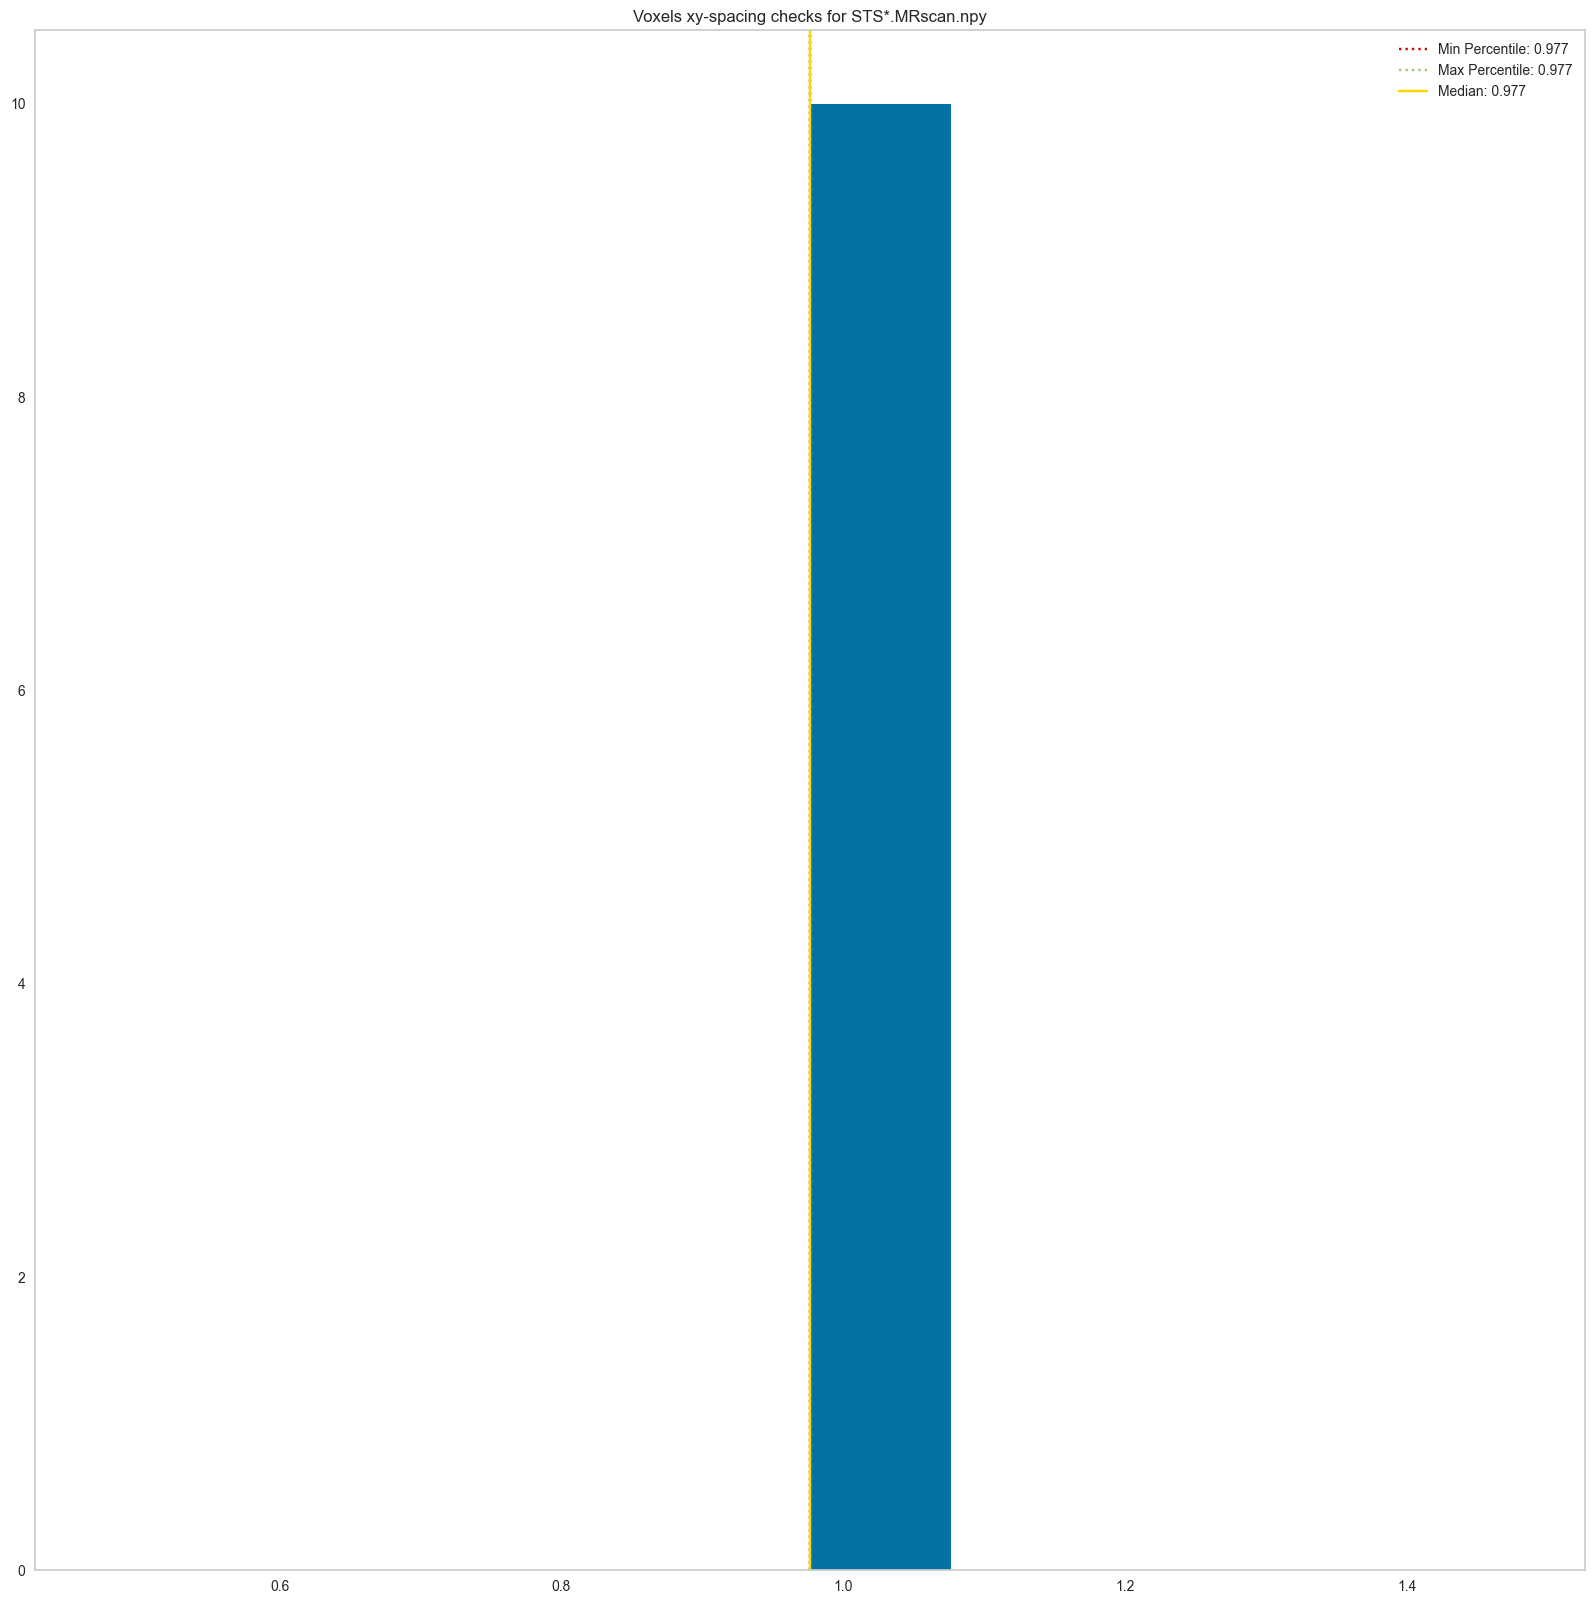

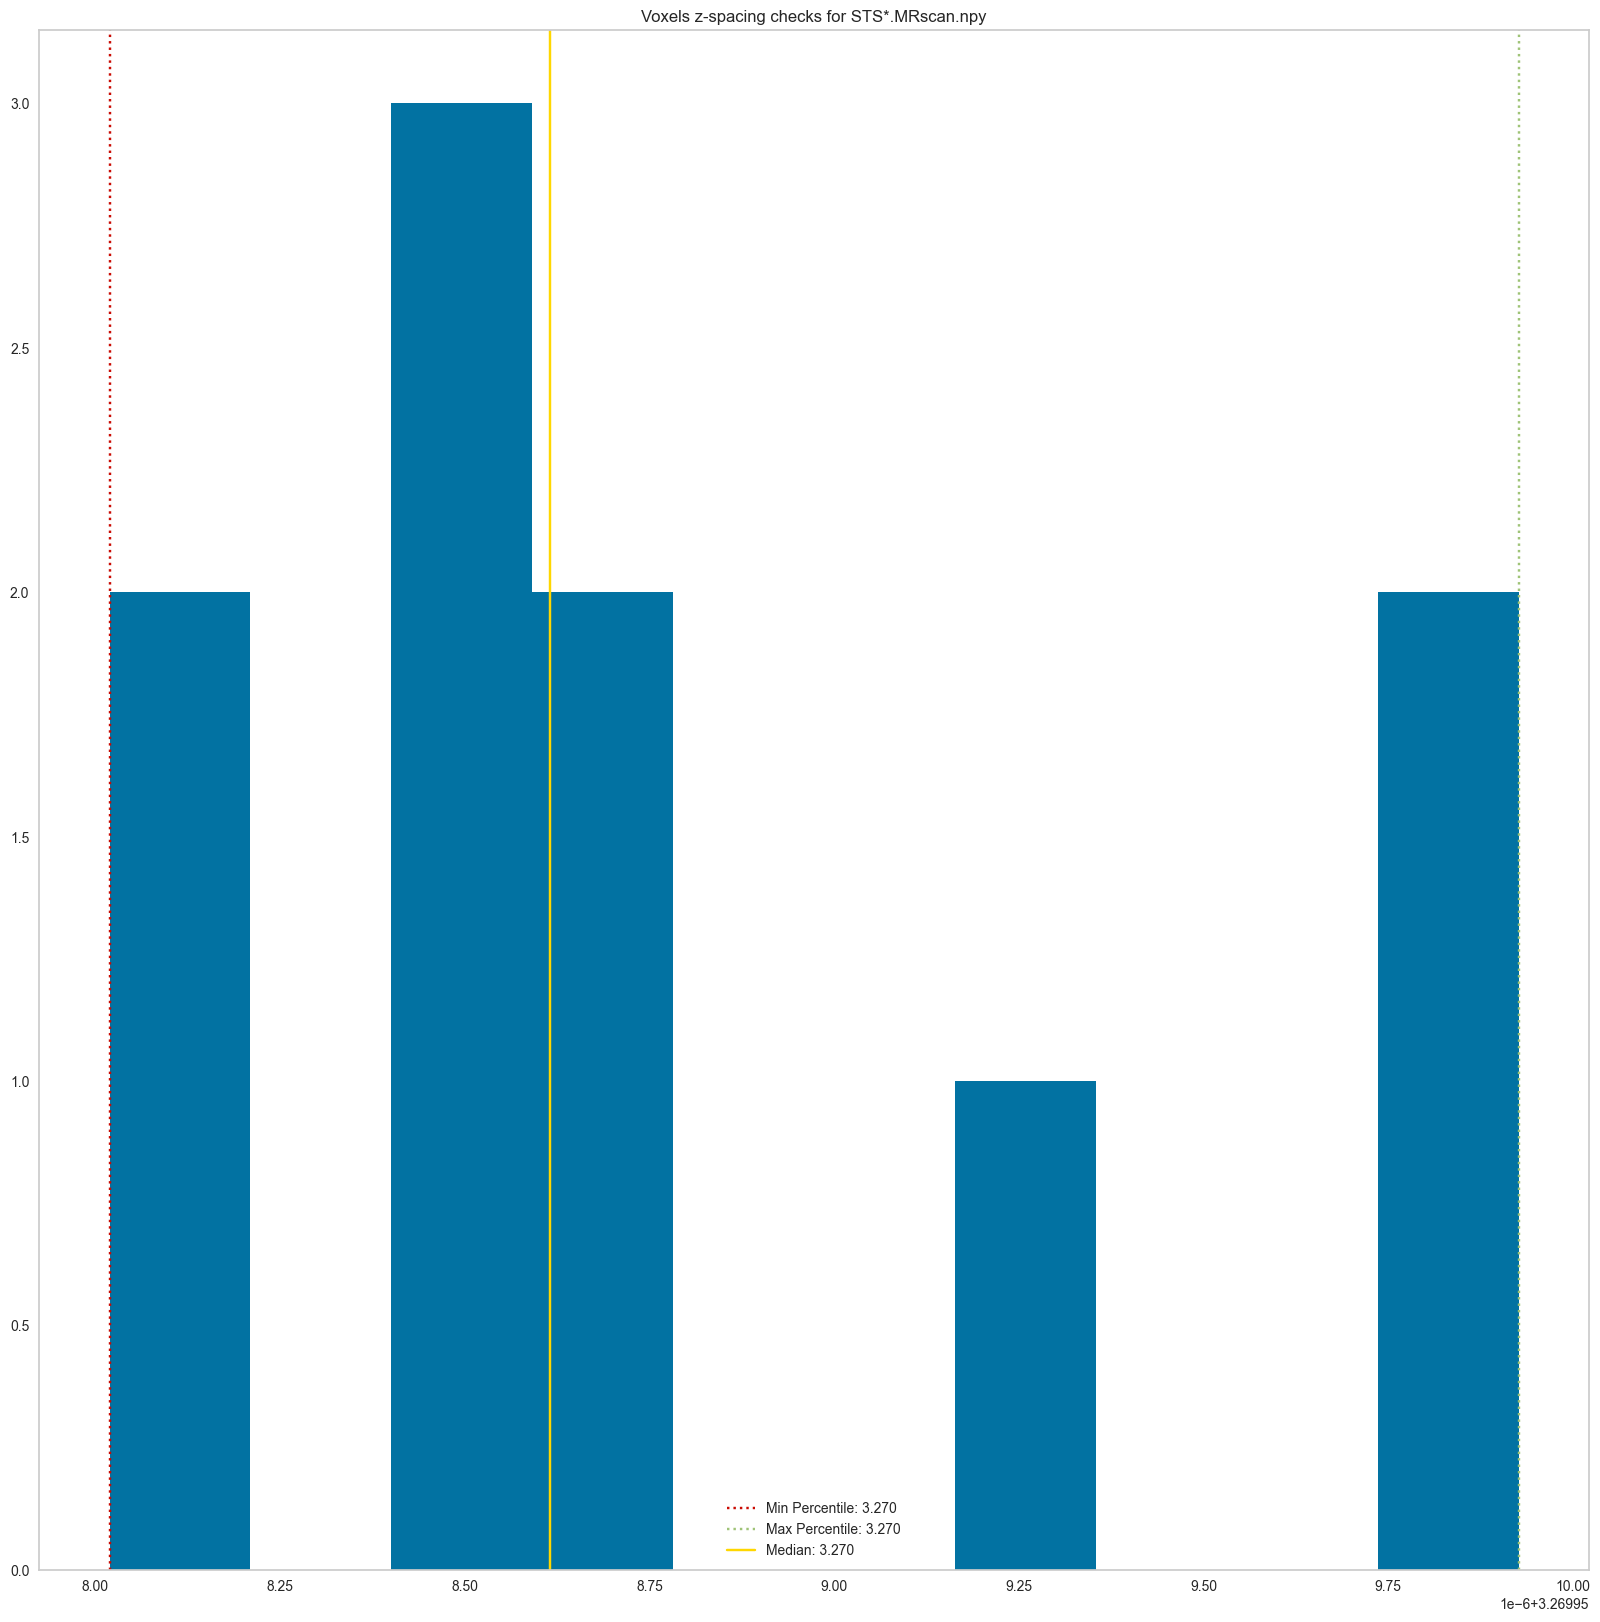

DONE
Elapsed time: 0.79 sec

--> PRE-RADIOMICS CHECKS -- WINDOW ... 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.60it/s]


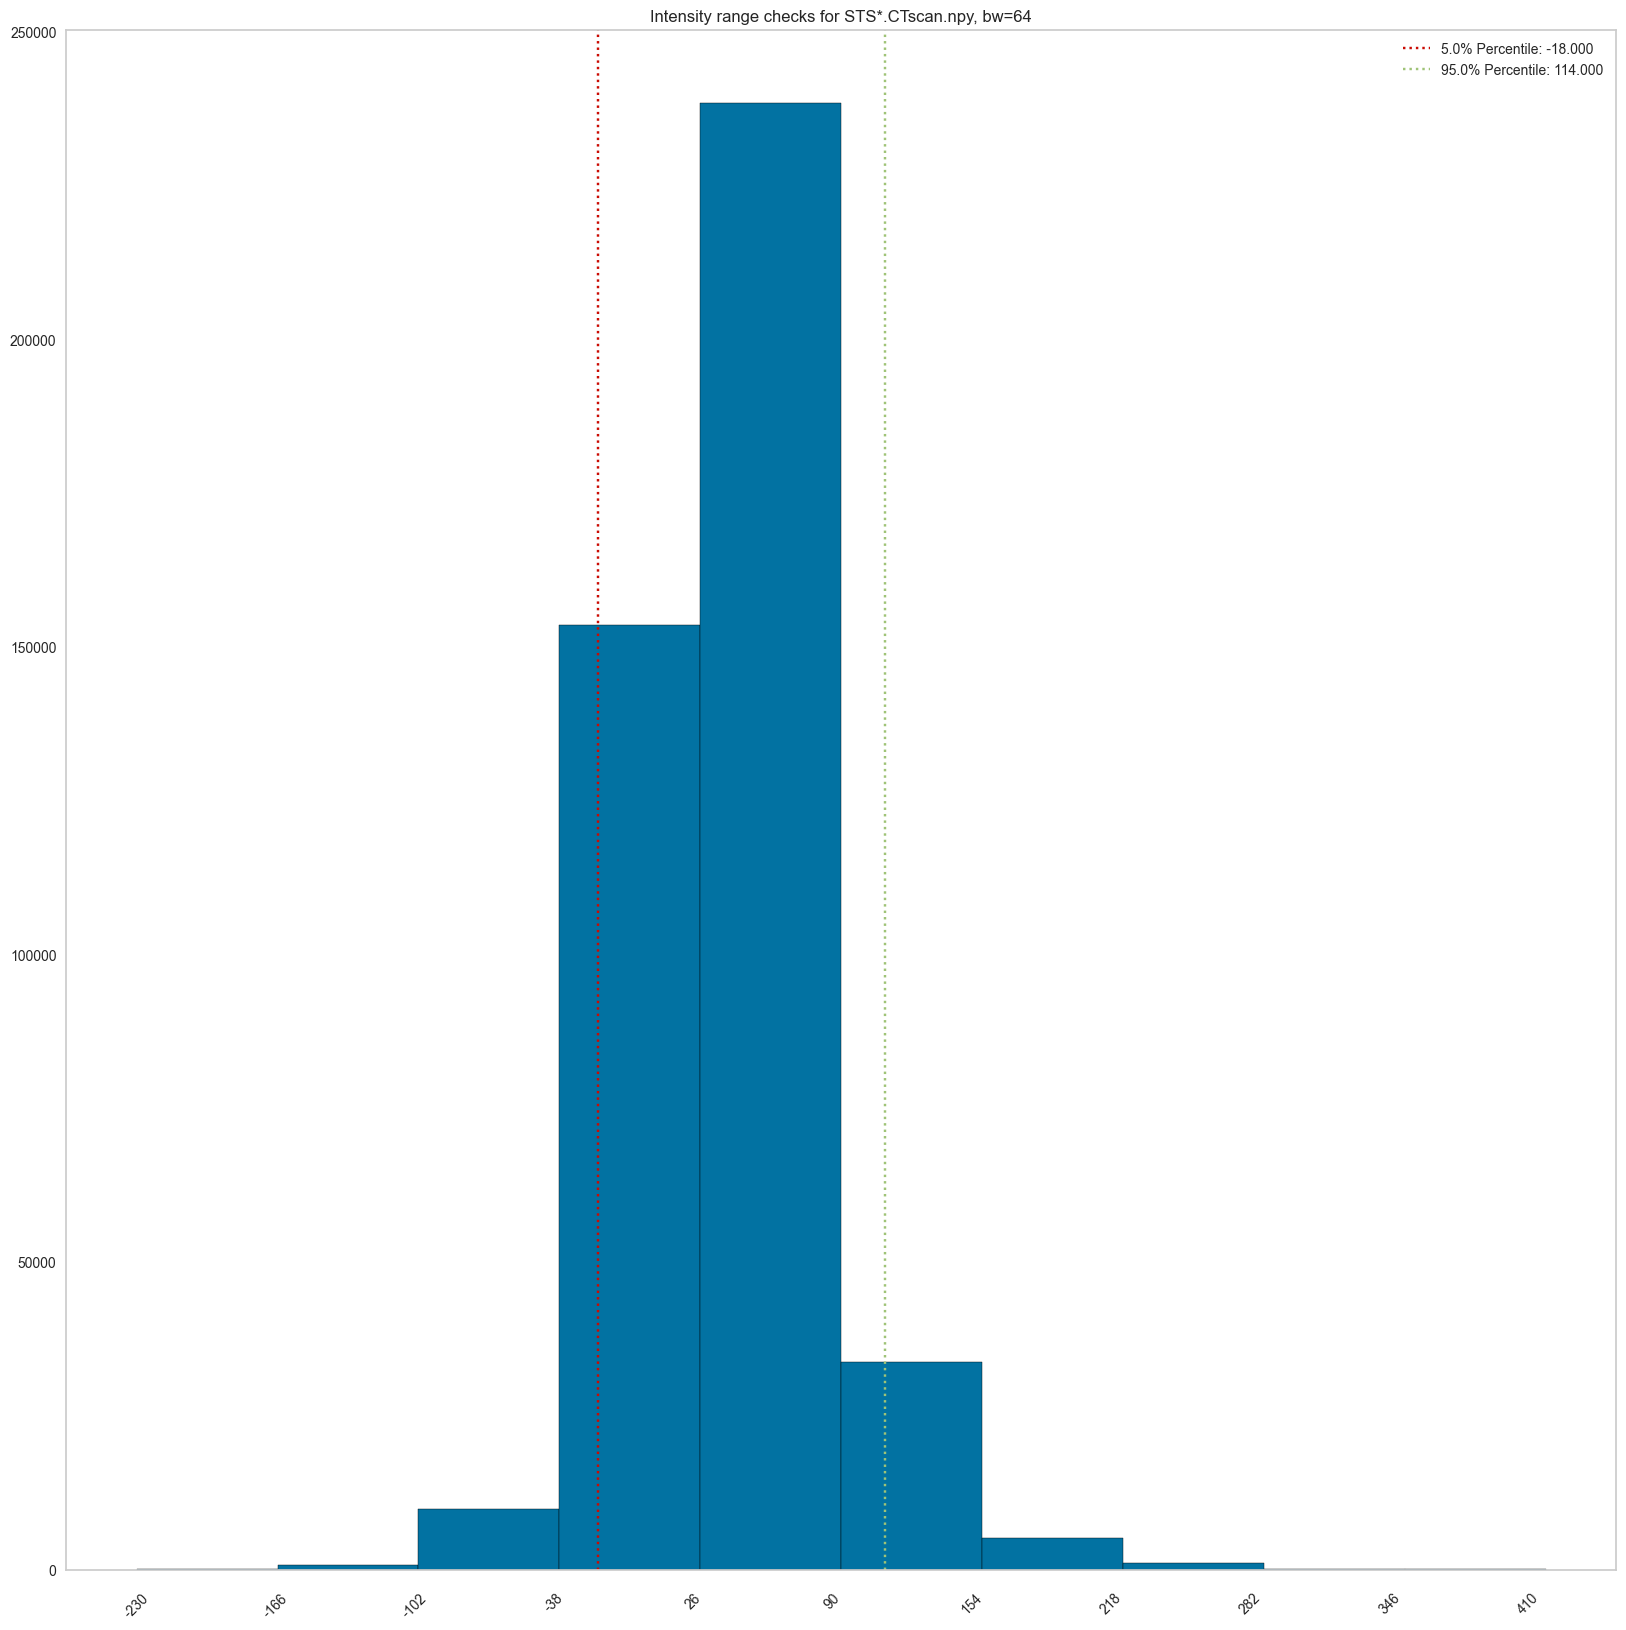

DONE
Elapsed time: 3.32 sec

--> TOTAL TIME FOR PRE-RADIOMICS CHECKS: 4.12 seconds
-------------------------------------------------------------------------------------


In [12]:
dm.pre_radiomics_checks(wildcards_dimensions=wildcards_dimensions, 
                        wildcards_window=wildcards_window, 
                        path_csv=path_csv_mass)

**Note**: You can also choose your own percentiles using the methods arguments. For example:



************************* PRE-RADIOMICS CHECKS *************************
--> PRE-RADIOMICS CHECKS -- DIMENSIONS ... 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.49it/s]


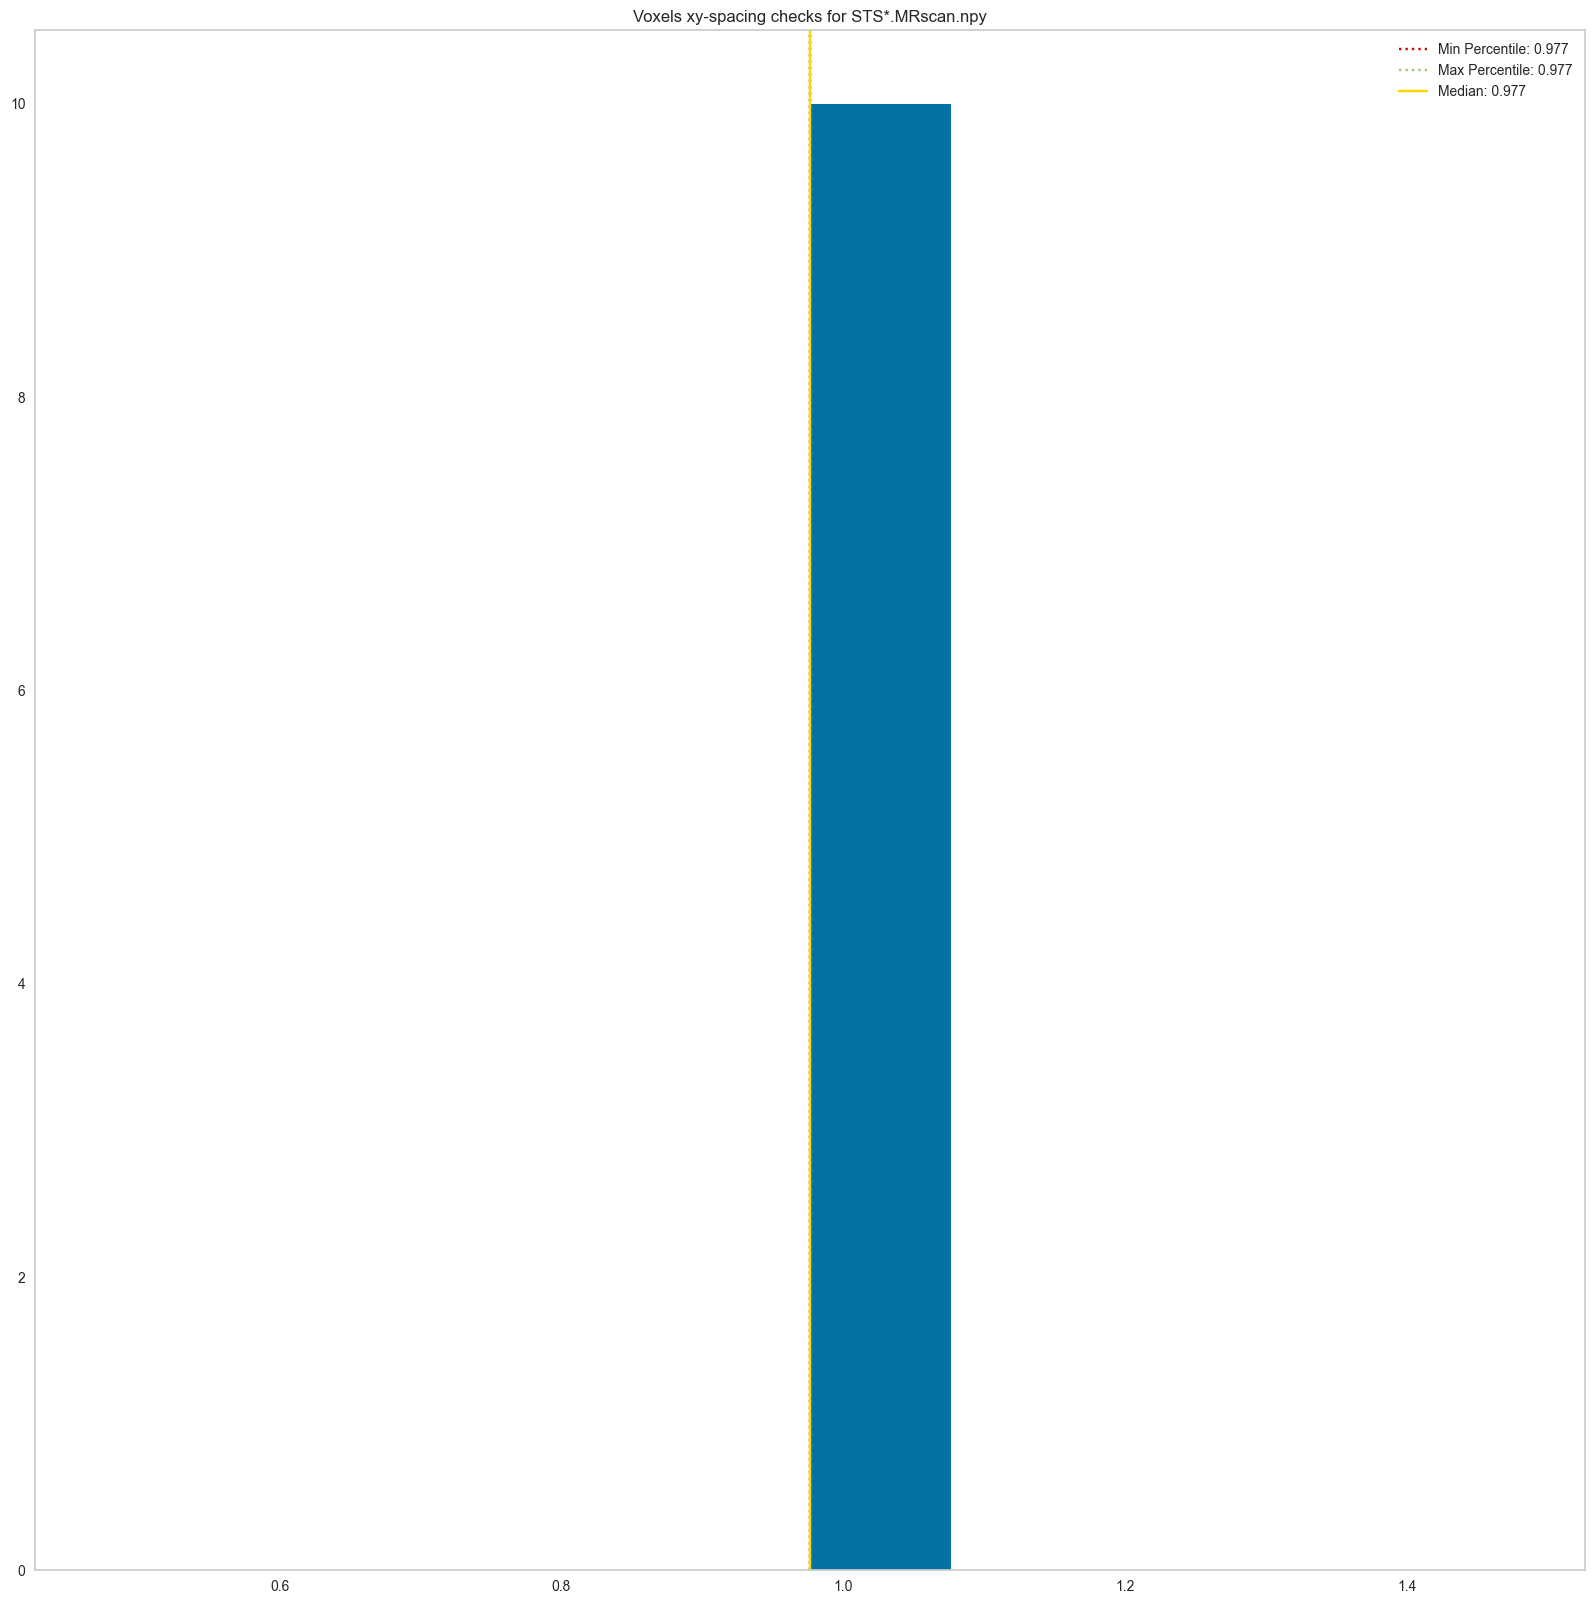

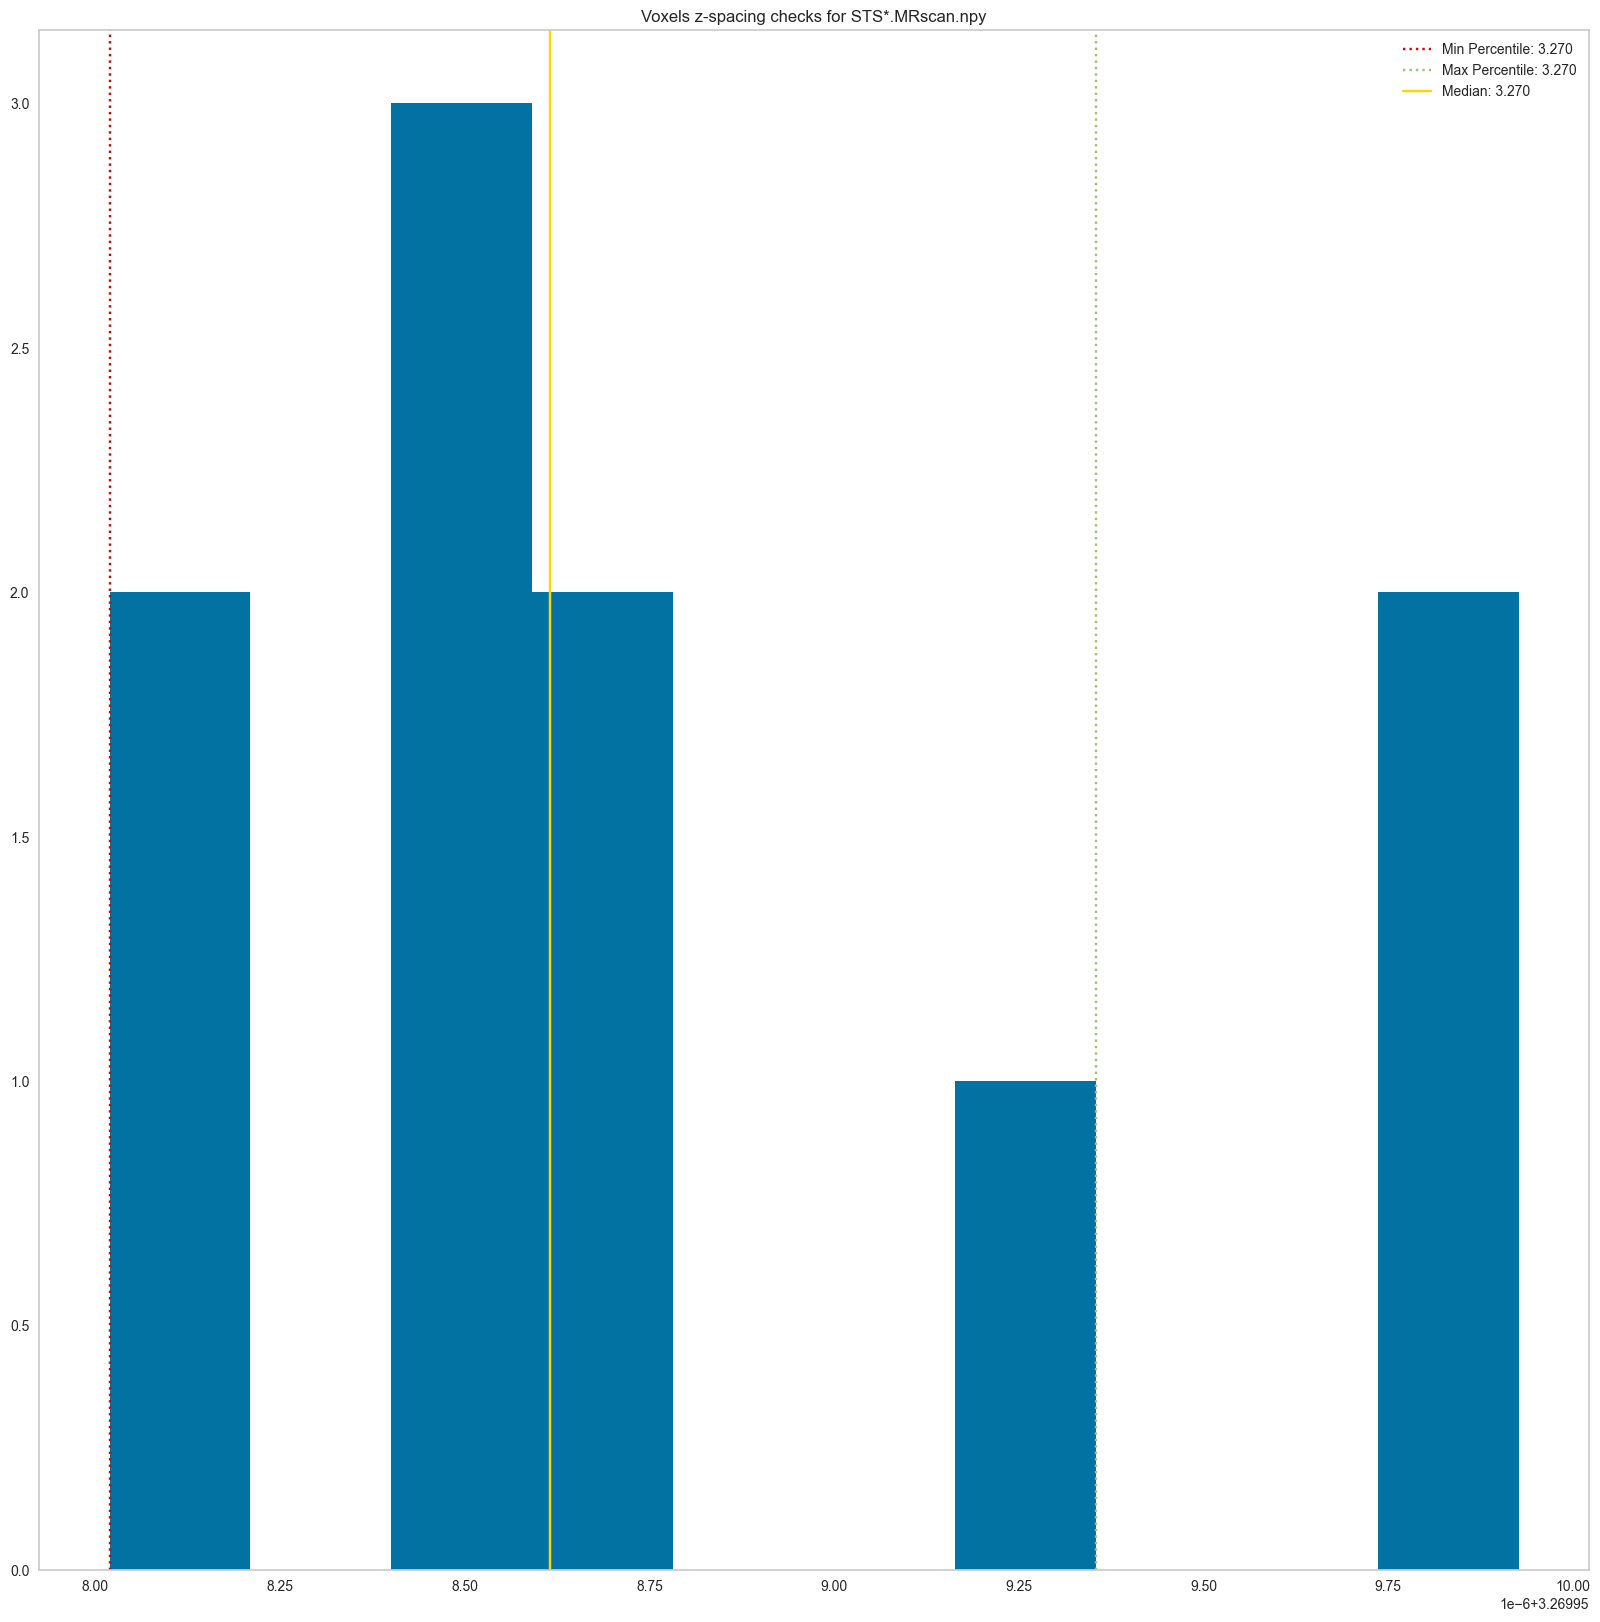

DONE
Elapsed time: 0.80 sec

--> PRE-RADIOMICS CHECKS -- WINDOW ... 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.60it/s]


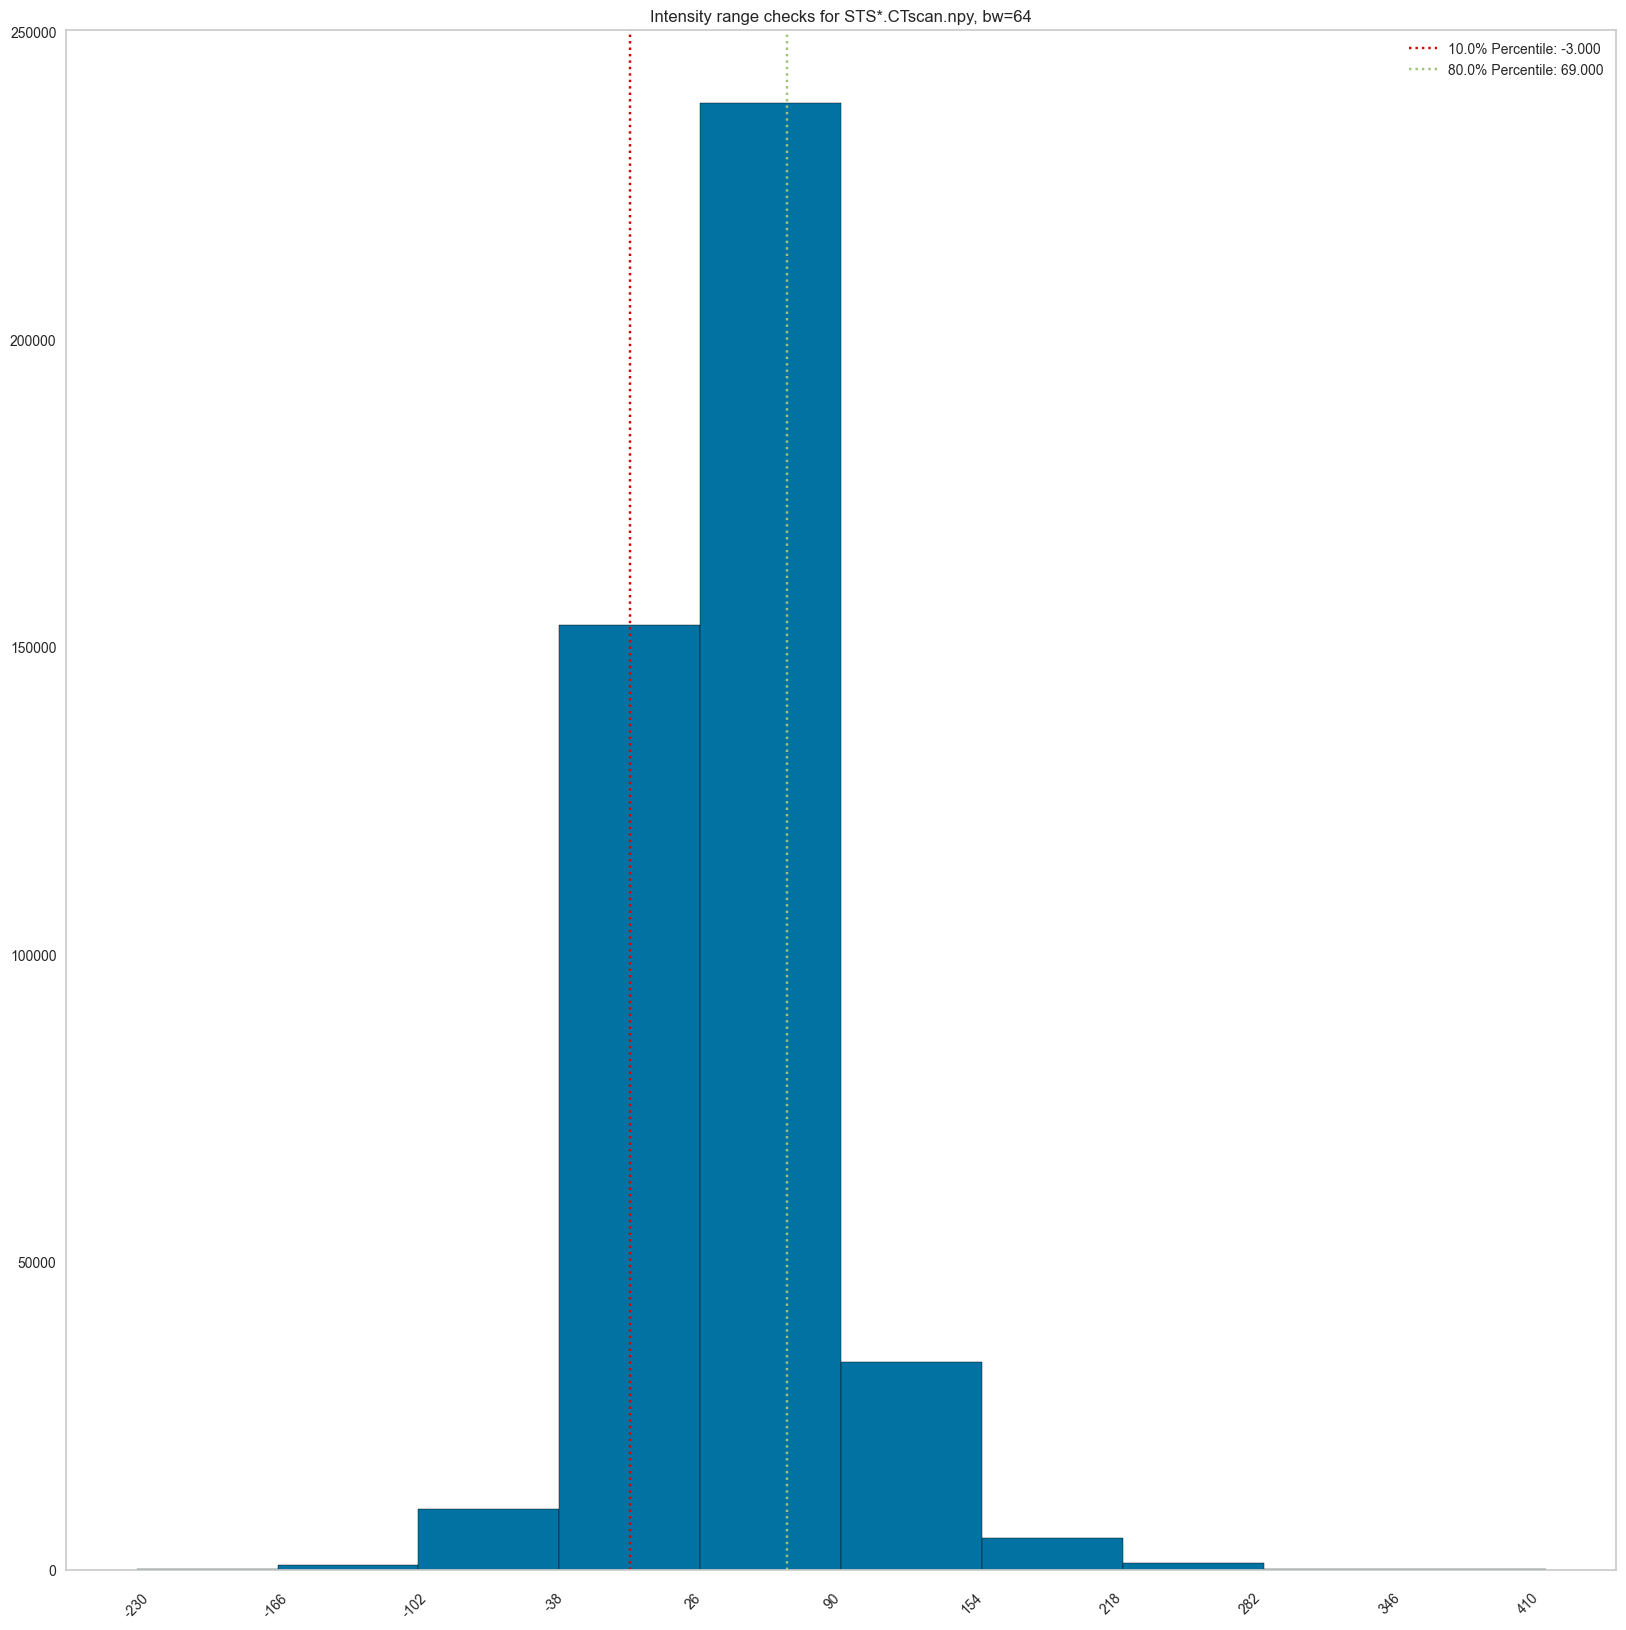

DONE
Elapsed time: 3.33 sec

--> TOTAL TIME FOR PRE-RADIOMICS CHECKS: 4.13 seconds
-------------------------------------------------------------------------------------


In [13]:
dm.pre_radiomics_checks(wildcards_dimensions=wildcards_dimensions, 
                        wildcards_window=wildcards_window, 
                        path_csv=path_csv_mass,
                        min_percentile=0.10, 
                        max_percentile=0.80)

The results must be now saved localy in a folder called *checks* as JSON files.

### Common errors to avoid:

- Bad dataset management: 
  - NIfTI: Make sure all your NIfTI files respect the file naming convention:
    - Imaging volume: patientID__ImagingScanName.ScanType(roiTypeLabel).nii.gz. For example *Glioma-TCGA-001__T1(tumorAuto).MRscan.nii.gz*
    - ROI mask: patientID__ImagingScanName(roiName).ROI.nii.gz. For example *Glioma-TCGA-001__T1(NET).ROI.nii.gz*
  - DICOM: Make sure the PatientID in the DICOM headers respect the following name: study-institution-id *(Ex: Glioma-TCGA-001)*
- No files found: make sure you have used the right names in the wildcard. If u saved your files locally then they should be available at ``path_save`` and the code will find it automatically.
- Same scans in different paths: Make sure you don't have the same scans (same filenames) in the different paths (maybe in a sub-folder).

Now that you understand how the ``DataManager`` class work, we recommend you follow the [MEDscan tutorial](https://colab.research.google.com/github/MahdiAll99/MEDimage/blob/dev/notebooks/tutorial/MEDscan-Tutorial.ipynb) for more details on the ``MEDscan`` class.